In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train', 'train.csv', 'sample_submission.csv']


In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import CosineSimilarity
from torchvision.transforms import ToTensor
import torchvision.models as models
from pathlib import Path
import PIL.Image
import random
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
path = Path('../input')

In [4]:
len(list((path/'train'/'train').iterdir()))

17500

In [5]:
tr_df = pd.read_csv(path/'train.csv')

In [6]:
tr_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [7]:
len(tr_df)

17500

In [8]:
class CactusDataset(Dataset):
    def __init__(self, path, labels):
        self.path = path
        self.labels = labels
        self.flist = list(labels.keys())
        self.len = len(self.flist)
        
    def __getitem__(self, index):
        fname = self.flist[index]
        img = ToTensor()(PIL.Image.open(self.path/fname))
        label = self.labels[fname]
        return img, label
    
    def __len__(self):
        return self.len

In [9]:
va_ratio = 0.1

In [10]:
tr_df, va_df = train_test_split(tr_df, train_size=1-va_ratio, test_size=va_ratio, random_state=42, stratify=tr_df['has_cactus'])

In [11]:
tr_labels = {k: v for k, v in zip(tr_df['id'], tr_df['has_cactus'])}
tr_ds = CactusDataset(path/'train'/'train', tr_labels)

In [12]:
va_labels = {k: v for k, v in zip(va_df['id'], va_df['has_cactus'])}
va_ds = CactusDataset(path/'train'/'train', va_labels)

In [13]:
len(tr_ds), len(va_ds)

(15750, 1750)

In [14]:
bs = 64
nw = 0

In [15]:
tr_dl = DataLoader(tr_ds, batch_size=bs, num_workers=nw, drop_last=True, pin_memory=True)

In [16]:
va_dl = DataLoader(va_ds, batch_size=bs, num_workers=nw, drop_last=True, pin_memory=True)

In [17]:
##################################  Arcface head #############################################################
import math
class Arcface(nn.Module):
    # implementation of additive margin softmax loss in https://arxiv.org/abs/1801.05599    
    def __init__(self, s=64., m=0.5):
        super(Arcface, self).__init__()
#         self.classnum = classnum
#         self.kernel = nn.Parameter(torch.Tensor(embedding_size, classnum).normal_().cuda())
        # initial kernel
        # self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.s = s # scalar value default is 64, see normface https://arxiv.org/abs/1704.06369
        self.set_m(m)
        
    def set_m(self, m):
        self.m = m # the margin value, default is 0.5
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.mm = self.sin_m * m  # issue 1
        self.threshold = math.cos(math.pi - m)
        
    def forward(self, cos_theta, label):
        cos_theta.clamp_(-1.0, 1.0)
        assert(not (cos_theta.clone().detach().cpu().numpy() > 1.).any())
        assert(not (cos_theta.clone().detach().cpu().numpy() < -1.).any())
        cos_theta_2 = torch.pow(cos_theta, 2)
        assert((cos_theta_2.clone().detach().cpu().numpy() <= 1.).all())
        sin_theta_2 = F.relu(1 - cos_theta_2)
#         assert((sin_theta_2.clone().detach().cpu().numpy() >= 0.).all())
        sin_theta = torch.sqrt(sin_theta_2)
        cos_theta_m = cos_theta * self.cos_m - sin_theta * self.sin_m

        output = cos_theta * 1.0 # a little bit hacky way to prevent in_place operation on cos_theta
        idx_ = torch.arange(0, len(label), dtype=torch.long)
        output[idx_, label] = cos_theta_m[idx_, label]
        output *= self.s # scale up in order to make softmax work, first introduced in normface

        output = F.cross_entropy(output, label)
        return output

In [18]:
class CosineEmbedding(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(CosineEmbedding, self).__init__()
        self.embedding = nn.Linear(num_classes, embedding_dim, bias=False)
        
    def forward(self, inputs):
        emb_norm = F.normalize(self.embedding.weight, dim=1)
        inp_norm = F.normalize(inputs, dim=1)
        return torch.mm(inp_norm, emb_norm)
#         return torch.mm(inputs, emb_norm)
#         return torch.mm(inputs, self.embedding.weight)

In [19]:
model = models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /tmp/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:06<00:00, 26055973.42it/s]


In [20]:
embedding_dim = 2
num_classes = 2

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [22]:
model.fc = CosineEmbedding(2048, num_classes)
model.cuda();

In [23]:
embedding = CosineEmbedding(embedding_dim, num_classes)
embedding.cuda();

In [24]:
for param in model.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

In [25]:
criterion = Arcface(s=64.0, m = 0.0)# 0.5 * ((2 * math.pi) / num_classes))
# criterion = nn.CrossEntropyLoss()

In [26]:
lr = 1e-3

In [27]:
optimizer = Adam(model.fc.parameters(), lr=lr)

In [28]:
optimizer.add_param_group({'params': embedding.parameters()})

In [29]:
num_epochs = 100
model_dir = Path('/kaggle/working/')

In [30]:
tr_metrics = []
va_metrics = []

In [31]:
for epoch in tqdm(range(num_epochs)):
# for epoch in range(num_epochs):
    print('Epoch: {:02d}\n'.format(epoch))
    
    iterations = 0
    running_loss = 0.0
    model.train()
    for inputs, targets in tqdm(tr_dl):
#     for inputs, targets in tr_dl:
        inputs = inputs.cuda()
        targets = targets.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = embedding(outputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        running_loss += loss
        tr_metrics.append((loss))
        iterations += 1
    
    tr_loss = running_loss / iterations
    print('Train: Loss: {:.6f}'.format(tr_loss))
    
    iterations = 0
    running_loss = 0.0
    running_ce = 0.0
    running_acc = 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(va_dl):
#         for inputs, targets in va_dl:
            inputs = inputs.cuda()
            targets = targets.cuda()
            outputs = model(inputs)
            outputs = embedding(outputs)
            
            loss = criterion(outputs, targets)
            loss = loss.item()
            running_loss += loss
            _, preds = torch.max(outputs, 1)
#             print(preds, targets.data)
            acc = torch.sum(preds == targets.data, dtype=torch.float32) / inputs.shape[0]
#             print(acc)
            running_acc += acc
            running_ce += F.cross_entropy(outputs, targets).mean().item()
            iterations += 1
            
    va_loss = running_loss / iterations
    va_acc = running_acc / iterations
    va_ce = running_ce / iterations
    va_metrics.append((va_loss, va_acc, va_ce))
    print('Val: Loss: {:.6f} Acc: {:.6f} CE: {:.6f}'.format(va_loss, va_acc, va_ce))
    print(embedding.embedding.weight)

Epoch: 00



Train: Loss: 6.772739


Val: Loss: 2.857605 Acc: 0.706597 CE: 0.643468
Parameter containing:
tensor([[-0.7114,  0.1098],
        [ 0.1417,  0.1292]], device='cuda:0', requires_grad=True)
Epoch: 01



Train: Loss: 1.730558


Val: Loss: 1.356764 Acc: 0.785301 CE: 0.637364
Parameter containing:
tensor([[-0.7353,  0.0311],
        [ 0.1440,  0.1290]], device='cuda:0', requires_grad=True)
Epoch: 02



Train: Loss: 0.934318


Val: Loss: 0.847680 Acc: 0.824653 CE: 0.637457
Parameter containing:
tensor([[-0.7357, -0.0331],
        [ 0.1460,  0.1287]], device='cuda:0', requires_grad=True)
Epoch: 03



Train: Loss: 0.642104


Val: Loss: 0.622405 Acc: 0.846065 CE: 0.640889
Parameter containing:
tensor([[-0.7200, -0.0930],
        [ 0.1474,  0.1290]], device='cuda:0', requires_grad=True)
Epoch: 04



Train: Loss: 0.490262


Val: Loss: 0.485517 Acc: 0.860532 CE: 0.645105
Parameter containing:
tensor([[-0.6880, -0.1516],
        [ 0.1481,  0.1299]], device='cuda:0', requires_grad=True)
Epoch: 05



Train: Loss: 0.389537


Val: Loss: 0.394823 Acc: 0.876157 CE: 0.650215
Parameter containing:
tensor([[-0.6388, -0.2085],
        [ 0.1485,  0.1312]], device='cuda:0', requires_grad=True)
Epoch: 06



Train: Loss: 0.319306


Val: Loss: 0.340824 Acc: 0.875579 CE: 0.656312
Parameter containing:
tensor([[-0.5780, -0.2584],
        [ 0.1486,  0.1328]], device='cuda:0', requires_grad=True)
Epoch: 07



Train: Loss: 0.274518


Val: Loss: 0.309080 Acc: 0.879051 CE: 0.661391
Parameter containing:
tensor([[-0.5302, -0.2899],
        [ 0.1486,  0.1345]], device='cuda:0', requires_grad=True)
Epoch: 08



Train: Loss: 0.251782


Val: Loss: 0.290569 Acc: 0.882523 CE: 0.662648
Parameter containing:
tensor([[-0.5130, -0.3006],
        [ 0.1491,  0.1357]], device='cuda:0', requires_grad=True)
Epoch: 09



Train: Loss: 0.239128


Val: Loss: 0.278881 Acc: 0.887153 CE: 0.661869
Parameter containing:
tensor([[-0.5089, -0.3035],
        [ 0.1499,  0.1365]], device='cuda:0', requires_grad=True)
Epoch: 10



In [32]:
cosine_distance = CosineSimilarity(dim=0, eps=1e-6)

In [33]:
cosine_distance(embedding.embedding.weight[0], embedding.embedding.weight[1]) 

tensor(-0.9831, device='cuda:0', grad_fn=<DivBackward0>)

In [34]:
embedding.embedding.weight

Parameter containing:
tensor([[-0.5353, -0.3304],
        [ 0.2139,  0.1942]], device='cuda:0', requires_grad=True)

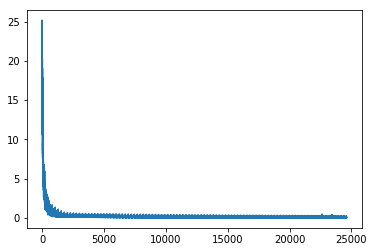

In [35]:
plt.plot(list(map(lambda t:t, tr_metrics)))

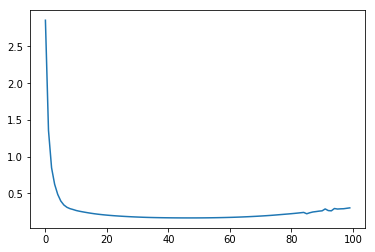

In [36]:
plt.plot(list(map(lambda t:t[0], va_metrics)))

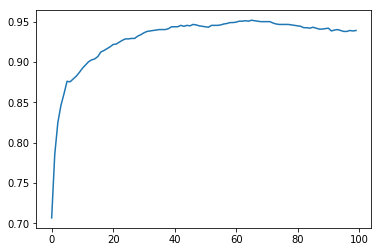

In [37]:
plt.plot(list(map(lambda t:t[1], va_metrics)))